In [ ]:
!pip install pymorphy3==2.0.2 pdfplumber==0.11.0 pandas==2.1.4 matplotlib==3.8.2 
!pip install wordcloud==1.9.3 scikit-learn==1.3.2 nltk==3.8.1 tqdm --force-reinstall
import warnings
warnings.filterwarnings('ignore')

import sys
import logging
logging.disable(sys.maxsize)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Успешно загружено глав: 22


100%|██████████| 22/22 [00:07<00:00,  3.08it/s]



Общее количество упоминаний:
Ленин      34
Сталин     62
Троцкий     2
Маркс      15
dtype: int64


<Figure size 1200x600 with 0 Axes>

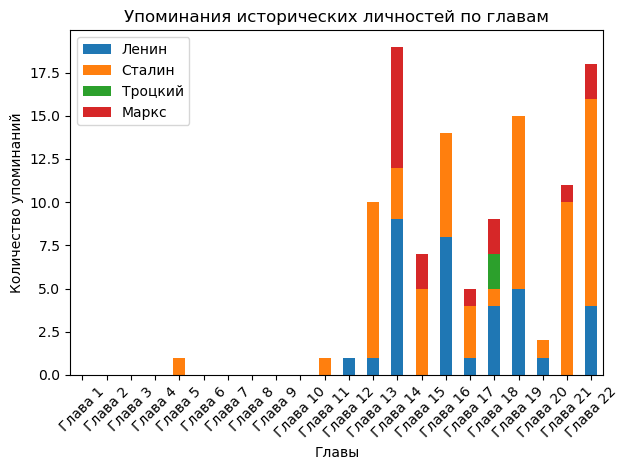

In [39]:

import nltk
nltk.download('stopwords')

from tqdm import tqdm
tqdm.pandas()

import pdfplumber
import pandas as pd
import re
import pymorphy3
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def extract_pdf_text(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text_pages = []
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text_pages.append(page_text)
            full_text = "\n".join(text_pages)
            
            chapters = re.split(r'\nГлава\s+\d+[\.\:\-]?\s*', full_text)
            chapters = [ch.strip() for ch in chapters if ch.strip()]
            return chapters[1:] if len(chapters) > 1 else chapters
    except Exception as e:
        raise RuntimeError(f"Ошибка чтения PDF: {str(e)}")

try:
    chapters = extract_pdf_text('source-4.pdf')
    if not chapters:
        raise ValueError("PDF не содержит текста или глав")
        
    df = pd.DataFrame({
        'chapter': [f"Глава {i+1}" for i in range(len(chapters))],
        'text': chapters
    })
    print(f"Успешно загружено глав: {len(chapters)}")
except Exception as e:
    print(f"Ошибка: {str(e)}")
    raise

morph = pymorphy3.MorphAnalyzer()
russian_stopwords = set(stopwords.words('russian')).union({
    'который', 'этот', 'весь', 'свой', 'год', 'когда', 'также', 'еще', 'уже'
})

def clean_text(text):
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^а-яё\s-]', ' ', text.lower())
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize(text):
    words = re.findall(r'\b[а-яё-]{3,}\b', text)
    lemmas = []
    for word in words:
        if word not in russian_stopwords:
            try:
                parsed = morph.parse(word)[0]
                if any(tag in parsed.tag for tag in {'PREP', 'CONJ', 'PRCL', 'INTJ'}):
                    continue
                lemmas.append(parsed.normal_form)
            except:
                continue
    return ' '.join(lemmas)

df['processed'] = df['text'].progress_apply(lambda x: lemmatize(clean_text(x)))

def count_mentions(text):
    return {
        'Ленин': len(re.findall(r'\bленин\b', text.lower())),
        'Сталин': len(re.findall(r'\bсталин\b', text.lower())),
        'Троцкий': len(re.findall(r'\bтроцкий\b', text.lower())),
        'Маркс': len(re.findall(r'\bмаркс\b', text.lower()))
    }

mentions_df = df['text'].apply(lambda x: pd.Series(count_mentions(x)))
df = pd.concat([df, mentions_df], axis=1)

print("\nОбщее количество упоминаний:")
print(mentions_df.sum())

if not df.empty:
    plt.figure(figsize=(12, 6))
    mentions_df.plot(kind='bar', stacked=True)
    plt.title('Упоминания исторических личностей по главам')
    plt.xlabel('Главы')
    plt.ylabel('Количество упоминаний')
    plt.xticks(range(len(df)), df['chapter'], rotation=45)
    plt.tight_layout()
    plt.show()




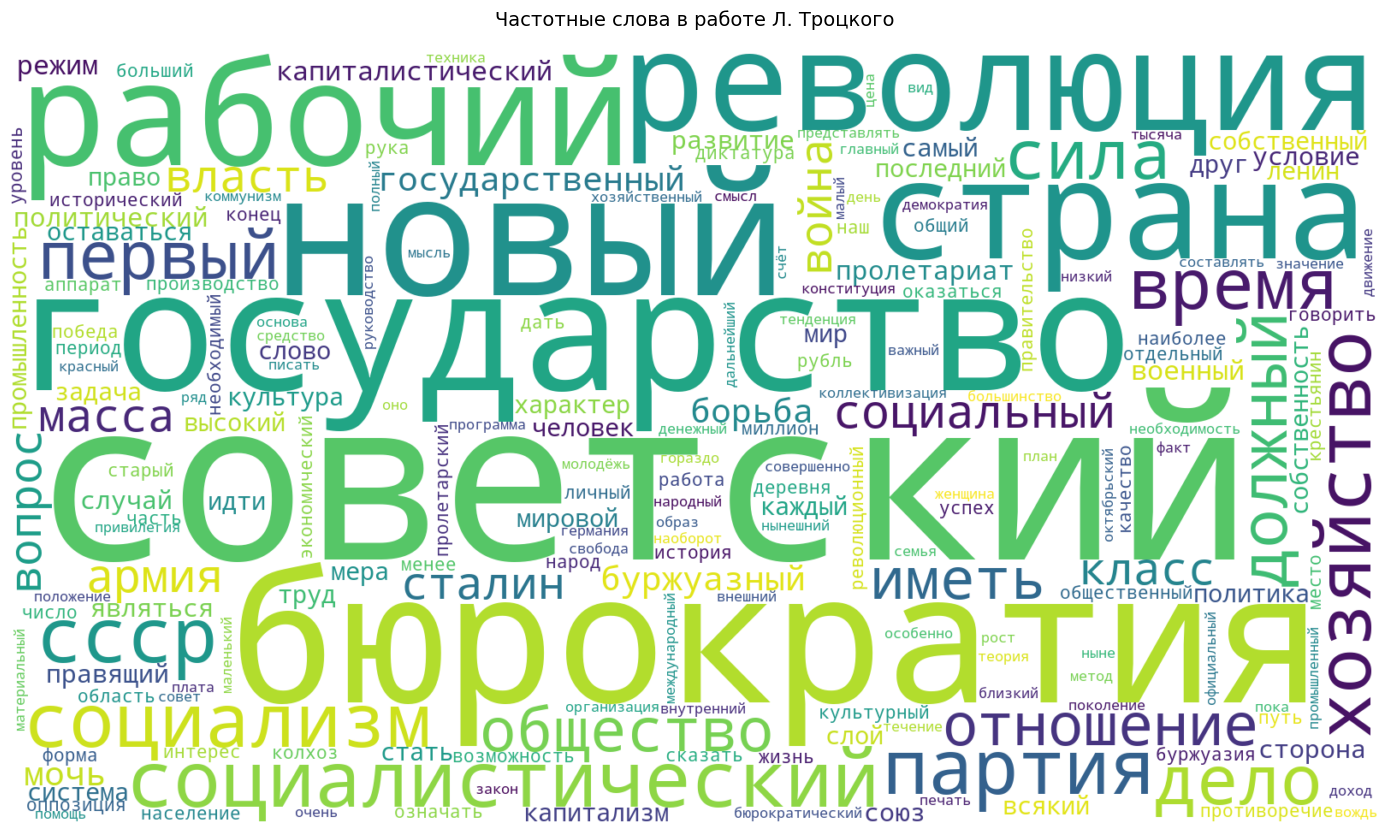

In [35]:
all_text = ' '.join(df['processed'])
if all_text.strip():
    wordcloud = WordCloud(
        width=1600,
        height=900,
        background_color='white',
        collocations=False,
        stopwords=russian_stopwords
    ).generate(all_text)

    plt.figure(figsize=(18, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Частотные слова в работе Л. Троцкого', pad=20, fontsize=14)
    plt.show()


In [37]:
# Функция для вывода тем
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Тема #{idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]))
        print()

# Тематическое моделирование
if not df['processed'].empty and len(df['processed']) > 1:
    vectorizer = TfidfVectorizer(
        max_df=0.85,
        min_df=2,
        max_features=1500,
        ngram_range=(1, 2)
    )
    
    lda = LatentDirichletAllocation(
        n_components=min(5, len(df)),
        learning_method='online',
        random_state=42,
        max_iter=20
    )

    X = vectorizer.fit_transform(df['processed'])
    if X.shape[1] > 0:
        lda.fit(X)
        print("\nОсновные темы документа:")
        print_topics(lda, vectorizer.get_feature_names_out())


Основные темы документа:
Тема #1:
демократия, новый конституция, личный собственность, государство, социализм, конституция, жандарм, укрепление диктатура, способность, укрепление

Тема #2:
термидор, советский термидор, корень, сплошной коллективизация, четыре, военный коммунизм, поворот, перерождение, сплошной, курс

Тема #3:
социальный, инфляция, деньга, армия, спекуляция, стахановский, стахановский движение, лига нация, производительность труд, лига

Тема #4:
душа население, достижение, показатель, душа, промышленный, достигнуть, важный, оценка, рост, население

Тема #5:
советский, который, свой, бюрократия, ссср, государство, сам, страна, новый, хозяйство

